In [1]:
%load_ext autoreload
%autoreload 2

import cPickle

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

/home/quickbeam/ilia_dev/python/miniconda/envs/blocks-py2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Setup: Network Weights and State Computer

In [2]:
# Load the network

from network import NetworkType, Network

lstm_net = Network(NetworkType.LSTM)

lstm_net.set_parameters('./seqgen_lstm.pkl')

map_chr_2_ind = cPickle.load(open("char_to_ind.pkl"))

In [3]:
# Set up state computer

from util import StateComputer

sc = StateComputer(lstm_net.cost_model, map_chr_2_ind)

## Basic facts about cost-matrix output

### First states == initial states

In [24]:
# Something nice to print at each iteration
msg = "Is the <{}> variable equal to its initial value after any random char?\n{}"
model_initial_vals = lstm_net.cost_model.get_parameter_values()
name_converter = {
    'sequencegenerator_cost_matrix_cells':
    '/sequencegenerator/with_fake_attention/transition/layer#0.initial_cells',
    'sequencegenerator_cost_matrix_cells#1':
    '/sequencegenerator/with_fake_attention/transition/layer#1.initial_cells',
    'sequencegenerator_cost_matrix_cells#2':
    '/sequencegenerator/with_fake_attention/transition/layer#2.initial_cells',
    'sequencegenerator_cost_matrix_states':
    '/sequencegenerator/with_fake_attention/transition/layer#0.initial_state',
    'sequencegenerator_cost_matrix_states#1':
    '/sequencegenerator/with_fake_attention/transition/layer#1.initial_state',
    'sequencegenerator_cost_matrix_states#2':
    '/sequencegenerator/with_fake_attention/transition/layer#2.initial_state' 
}
# read every char in vocab
reading_singleton_seqs = [sc.read_single_sequence([char_id]) for char_id in map_chr_2_ind.values()]
for state_name in sc.state_var_names:
    # getting initial value of variable
    initial_val = model_initial_vals[name_converter[state_name]]
    read_vals = [val[state_name] for val in reading_singleton_seqs]
    print(msg.format(state_name, all(np.all(v == initial_val) for v in read_vals)))

Is the <sequencegenerator_cost_matrix_cells> variable equal to its initial value after reading one char?
True
Is the <sequencegenerator_cost_matrix_cells#1> variable equal to its initial value after reading one char?
True
Is the <sequencegenerator_cost_matrix_cells#2> variable equal to its initial value after reading one char?
True
Is the <sequencegenerator_cost_matrix_states> variable equal to its initial value after reading one char?
True
Is the <sequencegenerator_cost_matrix_states#1> variable equal to its initial value after reading one char?
True
Is the <sequencegenerator_cost_matrix_states#2> variable equal to its initial value after reading one char?
True


### States One Step Behind
At position *t* states/cells reflect input at *t-1*

In [36]:
period_id = map_chr_2_ind['.']
# we vary only the first char in the sequence, the second one stays the same.
bigram_seqs = [(char_id, period_id) for char_id in map_chr_2_ind.values()]
reading_bigrams = [sc.read_single_sequence(bs) for bs in bigram_seqs]
for state_name in sc.state_var_names:
    for pos in (0, 1):
        read_vals = [val[state_name][pos] for val in reading_bigrams]
        print('Are values for <{}> at pos {} equal amongst themselves?'.format(state_name, pos))
        print(np.array_equal(read_vals[1:], read_vals[:-1]))

Are values for <sequencegenerator_cost_matrix_cells> at pos 0 equal amongst themselves?
True
Are values for <sequencegenerator_cost_matrix_cells> at pos 1 equal amongst themselves?
False
Are values for <sequencegenerator_cost_matrix_cells#1> at pos 0 equal amongst themselves?
True
Are values for <sequencegenerator_cost_matrix_cells#1> at pos 1 equal amongst themselves?
False
Are values for <sequencegenerator_cost_matrix_cells#2> at pos 0 equal amongst themselves?
True
Are values for <sequencegenerator_cost_matrix_cells#2> at pos 1 equal amongst themselves?
False
Are values for <sequencegenerator_cost_matrix_states> at pos 0 equal amongst themselves?
True
Are values for <sequencegenerator_cost_matrix_states> at pos 1 equal amongst themselves?
False
Are values for <sequencegenerator_cost_matrix_states#1> at pos 0 equal amongst themselves?
True
Are values for <sequencegenerator_cost_matrix_states#1> at pos 1 equal amongst themselves?
False
Are values for <sequencegenerator_cost_matrix_sta

## signal in the noise

In [48]:
from util import var_pos_mean

In [42]:
aux_var_name = "sequencegenerator_cost_matrix_cells#2"

In [100]:
coi = "O"
rest_chars = [map_chr_2_ind[char] for char in map_chr_2_ind if char != coi]
period_id = map_chr_2_ind['.']
bigrams = [(chr_id, period_id) for chr_id in rest_chars]

In [101]:
read_vals = [sc.read_single_sequence(b) for b in bigrams]

cell2_mean = var_pos_mean(read_vals, aux_var_name, 1)

In [103]:
coi_read = sc.read_single_sequence((map_chr_2_ind[coi], period_id))

coi_cell2 = coi_read[aux_var_name][1]

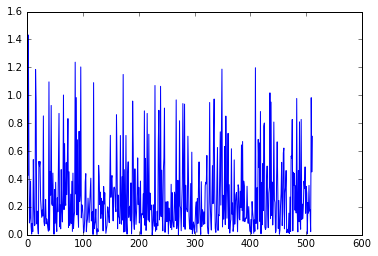

In [105]:
plt.plot(np.abs(cell2_mean - coi_cell2))

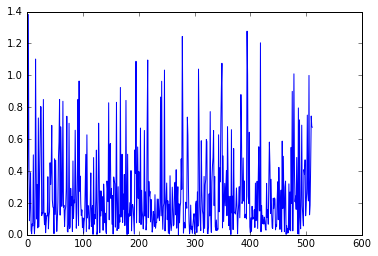

In [99]:
plt.plot(np.abs(cell2_mean - coi_cell2))

## Old Demo

In [4]:
aux_var_name = "sequencegenerator_cost_matrix_cells#2"

In [5]:
# demo_sent = "13:2 And Abram was very rich in cattle, in silver, and in gold."
# demo_sent = "16:11 Seek the LORD and his strength, seek his face continually."
demo_sent = "cats eat mice."
second_demo_sent = "cats eat flies"

In [6]:
demo_computed_vars = sc.read_single_sequence(demo_sent)

In [7]:
demo_cell = demo_computed_vars[aux_var_name]

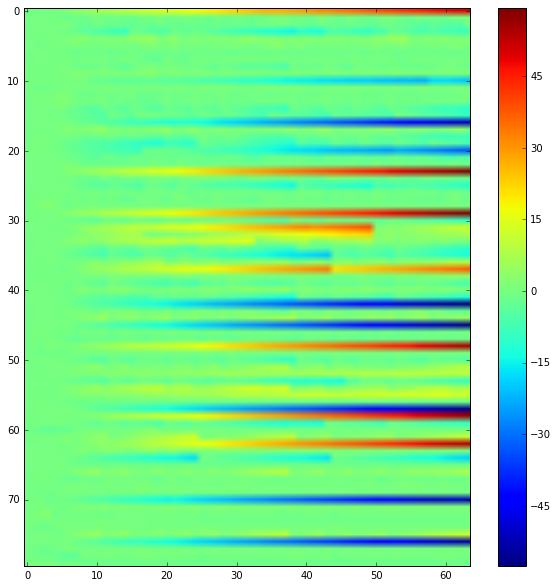

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(demo_cell[:,100:180].T)
plt.colorbar()

### Hinton Diagrams

In [12]:
from stoogeplot import hinton_diagram

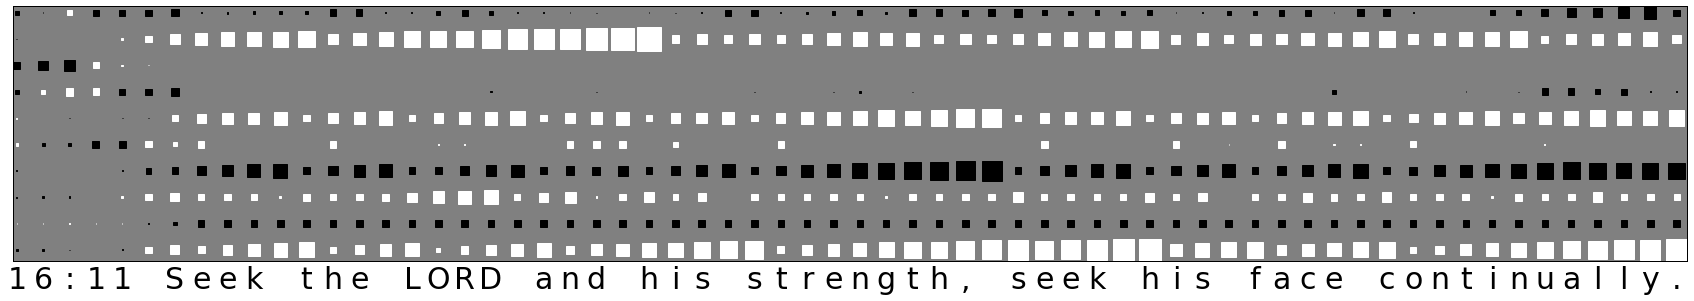

In [13]:
f = plt.figure(figsize=(30, 30))
ax = hinton_diagram(demo_cell[:,:10], xticks=demo_sent)
f.subplots_adjust(bottom=0.2)

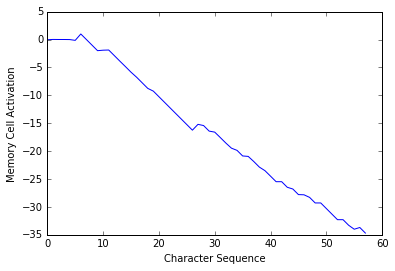

In [21]:
# ranges from 0 to len(input_char_seq) - 1
plt.plot(demo_cell2[:,10])
plt.ylabel("Activation")
plt.xlabel("Character Sequence")
# plt.show()

In [ ]:
# Get some example sequence from training data

import h5py

bible = h5py.File("bible.hdf5")

sequence = np.expand_dims(bible['character_seqs'][0], axis=1).T

In [ ]:
# Compute auxiliary variables and select last layer cells

auxiliaries = reader[2](sequence, np.ones((1, 47), dtype='f'))

# To make plotting nicer, swap seqlen and cell size axes
third_cell = auxiliaries[2].swapaxes(0, 2)

In [ ]:
# Verify consistent cell value!
# DON'T run this after the first time
third_cell_old = third_cell

In [ ]:
(third_cell_old == third_cell).all()

### Plotting Stuff...

This for now is just a demo of how easy it is to get at the various components of an NN and plot them

In [4]:
cats_mice = sc.read_single_sequence("cats eat mice")

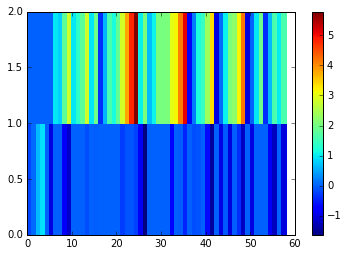

In [23]:
# f = plt.figure(figsize=(20, 20))
# plt.pcolormesh(np.expand_dims(third_cell[0][0], axis=0))
plt.pcolormesh(abram_cell2_simple[:,18:20].T)
# sets char IDs as tick labels on the X axis
# plt.xticks(input_positions, list("cats eat mice"))
# plt.yticks([])
# plt.ylim(0, 0.1)
plt.colorbar()
plt.show()

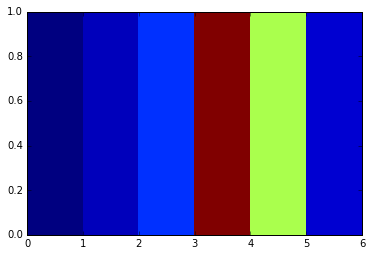

In [3]:
plt.pcolormesh(np.random.rand(1, 6))
plt.show()

## ICA

For now not used.

In [19]:
from sklearn.decomposition import FastICA

ica = FastICA()

# Crashes kernel atm
src = ica.fit_transform(demo_cell)